In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import corner
import ttvfast
import ttvfaststate
import driver
import mcmc
from datetime import datetime

# Functions and classes are defined for convenience and compatibility.

In [2]:
#Simplest Observation class possible. Replaces observations.py for now.
#Later to be Observation_TTV superclass of Observation.
class Obs(object):
    def __init__(self, times, errors):
        self.times = times
        self.errors = errors
        
#Plotting utilities. These functions will be moved in driver.py at a later time.
from scipy import stats
def plot_ttv(t1_times):
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(t1_times)),t1_times)
    diff = (np.arange(len(t1_times))*slope + intercept) - np.asarray(t1_times)
    return t1_times, diff
def plot_ttv_results(bundle, Ntrails, size):
    driver.return_trimmed_results(bundle, 50, [1,1], 0.5, plotting=False)
    print "Begin plotting..."
    Niter, mcmc, chain, chainlogp, true_state, obs, is_emcee, Nwalkers = bundle.mcmc_Niter, bundle.mcmc, bundle.mcmc_chain, bundle.mcmc_chainlogp, bundle.mcmc_initial_state, bundle.mcmc_obs, bundle.mcmc_is_emcee, bundle.mcmc_Nwalkers
    trimmedchain = bundle.mcmc_trimmedchain
    list_of_states = []
    for i in range(len(trimmedchain)):
        s = mcmc.state.deepcopy()
        s.set_params(chain[i])
        list_of_states.append(s)

    fig = plt.figure(figsize=(size[0],size[1]))
    #font = FontProperties()
    #font.set_family('serif')
    #font.set_style('italic')
    ax = plt.subplot(111)
    selected = np.sort(np.random.choice(len(list_of_states), Ntrails))
    print "Selected some {nt} samples to plot.".format(nt=Ntrails)
    for j in range(len(selected)):
        a = list_of_states[selected[j]]
        ax.plot(*a.get_ttv_plotting(obs), alpha=0.28, color="darkolivegreen")
        
    averageRandomState = mcmc.state.deepcopy()
    averageRandomChain = np.average(chain, axis=0)
    averageRandomState.set_params(averageRandomChain)
    ax.plot(*true_state.get_ttv_plotting(obs), color="purple")
    #plt.errorbar(obs.t, obs.rv, yerr=obs.err, fmt='.r')
    ax.set_xticklabels([])
    plt.grid()
    ax2=fig.add_axes([0.125, -0.63, 0.775, 0.7]) 
    #ax.set_ylabel("Initial TTV", fontproperties=font, fontsize=26)
    #ax2.set_ylabel("Average Result TTV", fontproperties=font, fontsize=26)
    ax.yaxis.label.set_size(26)
    ax2.yaxis.label.set_size(26)
    ax.tick_params(axis='both', labelsize=18)
    ax2.tick_params(axis='both', labelsize=18)
    plt.plot(*averageRandomState.get_ttv_plotting(obs), alpha=0.99,color="black")
    print "Resulting average params state (randomly sampledriver.ind):"
    #print averageRandomState.get_keys()
    print averageRandomState.get_params()
    #plt.errorbar(obs.t, obs.rv, yerr=obs.err, fmt='.r')
    ax2.set_xticklabels([])
    plt.grid()
    plt.close('all')
    return fig

# The following code should be in the Observation_TTV constructor and take a state as argument.

In [3]:
params_true_shifted = [
        0.00002878248, 10.9233301885, 0.0559950818813, 90.9205089025, 0.100354154645, 181.980514569, 90.4742591356,
        0.00061895914, 22.2663975745, 0.0567178996576, 92.4016920156, 0.462146380355, 1.65282682862, -108.441772505]
ttvfastsettings = [-1045-5.5, 0.54, 1697.9, 2, 0]

planet1 = ttvfast.models.Planet(*params_true_shifted[:7])
planet2 = ttvfast.models.Planet(*params_true_shifted[7:])
stellar_mass = 0.95573417954
planets = [planet1, planet2]            
#get results...
results = ttvfast.ttvfast(planets, stellar_mass, ttvfastsettings[0], ttvfastsettings[1], ttvfastsettings[2])
integer_indices, epochs, times, rsky, vsky = results["positions"]
t1_times = []
t2_times = []
count = 0
for i in range(len(times)):
    if(integer_indices[i]==0):
        if( not np.isclose(times[i],-2.0)):
            t1_times.append(times[i])
            count +=1
        else:
            break
    else:
        t2_times.append(times[i])
times_true = t1_times

#Lastly, create the observation class desired, ultimately will have error as argument.
modified_times1 = np.asarray(times_true)+(np.random.normal(0,1.e-8))
error_model1 = np.ones(len(times_true))*1.e-8
obs1 = Obs(modified_times1, error_model1)

# The following is needed to run emcee

In [4]:
ttvs = ttvfaststate.TTVState(params_true_shifted, ttvfastsettings)
scal = np.asarray([0.00002878248,
        1.0917340278625494e+01,
        5.6159310042858110e-02,
        9.0921164935951211e+01,
        -1.1729336712101943e-18,
        1.8094838714599581e+02,
        -8.7093652691581923e+01,
        0.00061895914,
        2.2266898036209028e+01,
        5.6691301931178648e-02,
        8.7598285693573246e+01,
        4.6220554014026838e-01,
        1.6437004273382669e+00,
        -1.9584857031843157e+01])*(np.random.normal(0,1.e-5))

# Since ttvfaststate.py is made to conform to standard, we can use the driver functionality.

In [5]:
ttv_bundle, h = driver.run_emcee("mass_bias", 4*14*500, ttvs, obs1, 4*14, scal, a=2., printing_every=40)

Progress: 0.2%, time: 2017-09-06 15:50:52.833625, current acceptance rate: 85.714%
Progress: 8.2%, time: 2017-09-06 15:51:17.840705, current acceptance rate: 33.58%
Progress: 16.2%, time: 2017-09-06 15:51:42.466815, current acceptance rate: 36.31%
Progress: 24.2%, time: 2017-09-06 15:52:08.661685, current acceptance rate: 37.721%
Progress: 32.2%, time: 2017-09-06 15:52:34.281108, current acceptance rate: 37.933%
Progress: 40.2%, time: 2017-09-06 15:53:00.622312, current acceptance rate: 38.086%
Progress: 48.2%, time: 2017-09-06 15:53:27.330469, current acceptance rate: 37.945%
Progress: 56.2%, time: 2017-09-06 15:53:52.446792, current acceptance rate: 38.04%
Progress: 64.2%, time: 2017-09-06 15:54:17.850637, current acceptance rate: 37.711%
Progress: 72.2%, time: 2017-09-06 15:54:43.709938, current acceptance rate: 37.698%
Progress: 80.2%, time: 2017-09-06 15:55:10.027401, current acceptance rate: 37.732%
Progress: 88.2%, time: 2017-09-06 15:55:34.459132, current acceptance rate: 37.67

Eliminated burn in, sampled every 1.
Begin plotting...
Selected some 20 samples to plot.
Resulting average params state (randomly sampledriver.ind):
[  2.87824799e-05   1.09233302e+01   5.59950818e-02   9.09205089e+01
   1.00354155e-01   1.81980515e+02   9.04742586e+01   6.18959140e-04
   2.22663976e+01   5.67178998e-02   9.24016922e+01   4.62146376e-01
   1.65282682e+00  -1.08441773e+02]


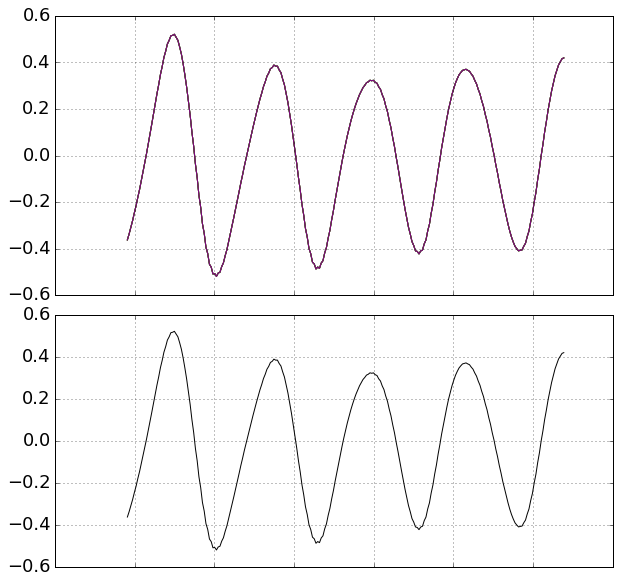

In [7]:
plot_ttv_results(ttv_bundle, 20, [10,5])